In [1]:
from pathlib import Path
import sys

ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

import os
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

from code_lib.utils import load_parts

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data

In [14]:
DATA_DIR = "../elliptic_dataset"
WALLETS = "wallets_features_until_t.csv"
EDGES_PREFIX = "AddrTxAddr_edgelist_part_"

edges_with_edge_labels = load_parts(DATA_DIR, EDGES_PREFIX)
nodes = pd.read_csv(os.path.join(DATA_DIR, WALLETS))

print(f"Nodes: {len(nodes):,}")
print(f"Edges: {len(edges_with_edge_labels):,}")
print(f"Timesteps: {nodes['Time step'].min()} - {nodes['Time step'].max()}")

Nodes: 920,691
Edges: 2,868,964
Timesteps: 1 - 49


In [15]:
labels = pd.read_csv(os.path.join(DATA_DIR, "wallets_classes.csv"))
print(len(labels))
nodes_with_classes = nodes.merge(labels, on='address', how='left')

822942


In [16]:
nodes_with_classes.head(5)

,address,Time step,in_num,in_total_fees,in_mean_fees,in_median_fees,in_total_btc_in,in_mean_btc_in,in_median_btc_in,in_fees_sum,...,out_out_BTC_mean_sum,out_out_BTC_mean_mean,out_out_BTC_mean_median,out_out_BTC_median_sum,out_out_BTC_median_mean,out_out_BTC_median_median,out_out_BTC_total_sum,out_out_BTC_total_mean,out_out_BTC_total_median,class
0,111112TykSw72ztDN2WJger4cynzWYC5w,25,1,0.169015,0.007042,0.007042,154.368773,6.432032,6.432032,0.169015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,25,1,0.000122,0.000122,0.000122,0.019890,0.019890,0.019890,0.000122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,1111DAYXhoxZx2tsRnzimfozo783x1yC2,29,2,0.000245,0.000123,0.000123,0.153667,0.076833,0.076833,0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,1111DAYXhoxZx2tsRnzimfozo783x1yC2,39,4,0.001405,0.000351,0.000351,0.162912,0.040728,0.012617,0.001405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,1111DAYXhoxZx2tsRnzimfozo783x1yC2,43,6,0.001889,0.000315,0.000242,0.219100,0.036517,0.014352,0.001889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [17]:
def build_future_illicit_labels(
    nodes_df,
    edges_df,
    time_horizon=3,
    min_timestep=1,
    max_timestep=46
):
    """
    For each wallet at each timestep, determine if it will transact with a NEW illicit node.
    
    NEW illicit node = node that either:
    1. Doesn't exist yet at timestep t, OR
    2. Exists but isn't marked as illicit yet at timestep t
    
    Args:
        nodes_df: DataFrame with columns ['address', 'Time step', 'class', ...features]
        edges_df: DataFrame with columns ['Time step', 'input_address', 'output_address']
        time_horizon: How many timesteps into the future to look
        min_timestep: First timestep to consider
        max_timestep: Last timestep to consider (must leave room for time_horizon)
    
    Returns:
        DataFrame with columns ['address', 'timestep', 'label', ...features]
    """
    print(f"Building labels with time_horizon={time_horizon}...")
    
    # get all illicit addresses (across all time)
    all_illicit = set(nodes_df[nodes_df['class'] == 1]['address'].values)
    print(f"Total illicit addresses: {len(all_illicit):,}")
    
    # pre-group edges by timestep for faster lookup
    print("Grouping edges by timestep...")
    edges_by_time = {}
    for t in edges_df['Time step'].unique():
        edges_by_time[t] = edges_df[edges_df['Time step'] == t]
    
    # pre-group nodes by timestep
    print("Grouping nodes by timestep...")
    nodes_by_time = {}
    for t in nodes_df['Time step'].unique():
        nodes_by_time[t] = nodes_df[nodes_df['Time step'] == t]
    
    # for each timestep, get addresses that exist and are already illicit
    print("Computing existing illicit nodes at each timestep...")
    existing_illicit_at_t = {}
    for t in range(min_timestep, max_timestep + 1):
        nodes_up_to_t = nodes_df[nodes_df['Time step'] <= t]
        existing_addresses = set(nodes_up_to_t['address'].values)
        existing_illicit_at_t[t] = existing_addresses & all_illicit
    
    # build dataset
    data_rows = []
    valid_timesteps = [t for t in range(min_timestep, max_timestep + 1) if t + time_horizon <= nodes_df['Time step'].max()]
    
    print(f"\nProcessing timesteps {min(valid_timesteps)} to {max(valid_timesteps)}...")
    
    for t in tqdm(valid_timesteps, desc="Timesteps"):

        # get adresses existing at time t
        addresses_at_t = nodes_df[nodes_df['Time step'] == t]['address'].unique()
        
        # get nodes up to time t for feature lookup
        nodes_at_t = nodes_df[nodes_df['Time step'] <= t]
        
        # Get illicit nodes that are NEW
        future_new_illicit = all_illicit - existing_illicit_at_t[t]
        
        # Find which addresses will transact with NEW illicit in the future
        future_illicit_transactors = set()
        
        for future_t in range(t + 1, t + time_horizon + 1):
            if future_t not in edges_by_time:
                continue
            
            edges_future = edges_by_time[future_t]
            
            # find edges to/from NEW illicit nodes
            to_new_illicit = edges_future[edges_future['output_address'].isin(future_new_illicit)]
            from_new_illicit = edges_future[edges_future['input_address'].isin(future_new_illicit)]
            
            # Collect addresses that transact with NEW illicit
            future_illicit_transactors.update(to_new_illicit['input_address'].values)
            future_illicit_transactors.update(from_new_illicit['output_address'].values)
        
        # get latest features for each address at time t
        latest_features = nodes_at_t.sort_values('Time step').groupby('address').last()
        
        # Create rows for each address
        for addr in addresses_at_t:
            if addr not in latest_features.index:
                continue
            
            # skip if already illicit or has transacted with illicit
            if addr in existing_illicit_at_t[t]:
                continue
            
            # Label: 1 if will transact with NEW illicit, 0 otherwise
            label = 1 if addr in future_illicit_transactors else 0
            
            # get features
            features = latest_features.loc[addr].to_dict()
            features['address'] = addr
            features['timestep'] = t
            features['label'] = label
            
            data_rows.append(features)
    
    df = pd.DataFrame(data_rows)
    print(f"\nCreated dataset with {len(df):,} samples")
    print(f"Positive samples: {df['label'].sum():,} ({df['label'].mean()*100:.2f}%)")
    print(f"Negative samples: {(1-df['label']).sum():,} ({(1-df['label'].mean())*100:.2f}%)")
    
    return df

In [18]:
TIME_HORIZON = 3
MIN_TIMESTEP = 1
MAX_TIMESTEP = 46

df = build_future_illicit_labels(
    nodes_with_classes,
    edges_with_edge_labels,
    time_horizon=TIME_HORIZON,
    min_timestep=MIN_TIMESTEP,
    max_timestep=MAX_TIMESTEP
)

Building labels with time_horizon=3...
Total illicit addresses: 14,266
Grouping edges by timestep...
Grouping nodes by timestep...
Computing existing illicit nodes at each timestep...

Processing timesteps 1 to 46...


Timesteps: 100%|██████████| 46/46 [01:13<00:00,  1.61s/it]



Created dataset with 855,220 samples
Positive samples: 339 (0.04%)
Negative samples: 854,881 (99.96%)


In [19]:
def balanced_sample(df, label_col='label', random_state=42):
    positive = df[df[label_col] == 1]
    negative = df[df[label_col] == 0]
    
    n_positive = len(positive)
    n_negative = len(negative)
    
    print(f"Original: {n_positive:,} positive, {n_negative:,} negative")
    
    # Undersample majority class
    if n_positive < n_negative:
        negative_sampled = negative.sample(n=n_positive, random_state=random_state)
        balanced = pd.concat([positive, negative_sampled])
    else:
        positive_sampled = positive.sample(n=n_negative, random_state=random_state)
        balanced = pd.concat([positive_sampled, negative])
    

    balanced = balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    print(f"Balanced: {len(balanced):,} samples ({balanced[label_col].mean()*100:.1f}% positive)")
    
    return balanced



In [20]:
df.head(5)

,Time step,in_num,in_total_fees,in_mean_fees,in_median_fees,in_total_btc_in,in_mean_btc_in,in_median_btc_in,in_fees_sum,in_fees_mean,...,out_out_BTC_median_sum,out_out_BTC_median_mean,out_out_BTC_median_median,out_out_BTC_total_sum,out_out_BTC_total_mean,out_out_BTC_total_median,class,address,timestep,label
0,1.0,1.0,0.0000,0.0000,0.0000,852.164680,852.164680,852.164680,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,1125gA55bMKdCM5zuQGb2DTU1qMPnnGAcT,1,0
1,1.0,1.0,0.0001,0.0001,0.0001,1.154375,1.154375,1.154375,0.0001,0.0001,...,53.275144,53.275144,53.275144,53.275144,53.275144,53.275144,3.0,1126APrcFVWFK4iZhg7Apm1TAiMvyX1BXK,1,0
2,1.0,1.0,0.0000,0.0000,0.0000,852.164680,852.164680,852.164680,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,1127EVekJYumhffn6cG98GNaySwmxPEPqb,1,0
3,1.0,1.0,0.0000,0.0000,0.0000,852.164680,852.164680,852.164680,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,1129A9dFqy4ABDsGQ8RGusbMWYBoZc4myc,1,0
4,1.0,1.0,0.0001,0.0001,0.0001,1.593246,1.593246,1.593246,0.0001,0.0001,...,1.592346,0.796173,0.796173,3.184691,1.592346,1.592346,3.0,112BG7qVC6MCKrCMvNkgBjSoQdXuDU2VEe,1,0


In [21]:
print(df.columns.to_list())

['Time step', 'in_num', 'in_total_fees', 'in_mean_fees', 'in_median_fees', 'in_total_btc_in', 'in_mean_btc_in', 'in_median_btc_in', 'in_fees_sum', 'in_fees_mean', 'in_fees_median', 'in_size_sum', 'in_size_mean', 'in_size_median', 'in_in_txs_degree_sum', 'in_in_txs_degree_mean', 'in_in_txs_degree_median', 'in_out_txs_degree_sum', 'in_out_txs_degree_mean', 'in_out_txs_degree_median', 'in_num_input_addresses_sum', 'in_num_input_addresses_mean', 'in_num_input_addresses_median', 'in_num_output_addresses_sum', 'in_num_output_addresses_mean', 'in_num_output_addresses_median', 'in_total_BTC_sum', 'in_total_BTC_mean', 'in_total_BTC_median', 'in_in_BTC_min_sum', 'in_in_BTC_min_mean', 'in_in_BTC_min_median', 'in_in_BTC_max_sum', 'in_in_BTC_max_mean', 'in_in_BTC_max_median', 'in_in_BTC_mean_sum', 'in_in_BTC_mean_mean', 'in_in_BTC_mean_median', 'in_in_BTC_median_sum', 'in_in_BTC_median_mean', 'in_in_BTC_median_median', 'in_in_BTC_total_sum', 'in_in_BTC_total_mean', 'in_in_BTC_total_median', 'in_out

In [23]:
illicit_count = df[df['class'] == 1].shape[0]
print(illicit_count)

0


In [24]:
TRAIN_CUTOFF = 33  # Train on t=1 to t=37
TEST_CUTOFF = 46   # Test on t=38 to t=46

train_df = df[df['timestep'] <= TRAIN_CUTOFF].copy()
test_df = df[(df['timestep'] >= TRAIN_CUTOFF + TIME_HORIZON) & (df['timestep'] <= TEST_CUTOFF)].copy()

train_df_reduced = train_df.drop(columns=[c for c in nodes_with_labels.columns if c in {'first_block_apepared_in', 'first_sent_block', 'first_received_block','last_block_appeared_in','lifetime_in_blocks','num_timesteps_appeared_in','class','label'} or __import__('re').search(r'_(total|min|max|mean|median)$', c)], errors='ignore')
test_df_reduced = test_df.drop(columns=[c for c in nodes_with_labels.columns if c in {'first_block_apepared_in', 'first_sent_block', 'first_received_block', 'last_block_appeared_in','lifetime_in_blocks','num_timesteps_appeared_in','class','label'} or __import__('re').search(r'_(total|min|max|mean|median)$', c)], errors='ignore') 

In [25]:
train_df_balanced = balanced_sample(train_df_reduced, random_state=42)
test_df_balanced = balanced_sample(test_df_reduced, random_state=42)

Original: 235 positive, 578,859 negative
Balanced: 470 samples (50.0% positive)
Original: 71 positive, 241,362 negative
Balanced: 142 samples (50.0% positive)


In [26]:
train_df_balanced.head(5)

,Time step,in_num,in_total_fees,in_mean_fees,in_median_fees,in_total_btc_in,in_mean_btc_in,in_median_btc_in,in_fees_sum,in_size_sum,...,out_in_BTC_total_sum,out_out_BTC_min_sum,out_out_BTC_max_sum,out_out_BTC_mean_sum,out_out_BTC_median_sum,out_out_BTC_total_sum,class,address,timestep,label
0,18.0,20.0,0.003560,0.000178,0.000178,254.198239,12.709912,14.597830,0.003560,4509.0,...,508.403598,19.070649,489.325829,254.198239,254.198239,508.396478,3.0,18p9Ftp3m4435tdpZTvoBsm3yjUgkvTF2b,18,1
1,20.0,1.0,0.022297,0.002027,0.002027,4685.865642,425.987786,425.987786,0.022297,28171.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,16UgFD82KPaT4oqNkao5x66FYuNYbxpkFZ,20,1
2,12.0,1.0,0.104612,0.017435,0.017435,35.931099,5.988516,5.988516,0.104612,386718.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,1Kzx8Hc4kPwTkWfnsRAKa7FhYbRVxfH96z,12,1
3,10.0,2.0,0.000000,0.000000,0.000000,1737.591911,868.795956,868.795956,0.000000,626842.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,1PeWVMWCqhfjpYUf6q7ZeEMhTn1SCjz3nW,10,0
4,7.0,1.0,0.000100,0.000100,0.000100,2.339970,2.339970,2.339970,0.000100,520.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,16BrdRMyXr1fAfkjje64u7phfbK44bMvEj,7,0


In [27]:

X_train = train_balanced_reduced_features = train_df_balanced.drop(columns=['address', 'timestep', 'Time step', 'label'])
y_train = train_df_balanced['label']

X_test = test_df_reduced.drop(columns=['address', 'timestep', 'Time step', 'label'])
y_test = test_df_reduced['label']

In [28]:
print(f"\nX_train: {X_train.shape}")
print(f"y_train: {y_train.shape}, {y_train.mean()*100:.1f}% positive")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}, {y_test.mean()*100:.1f}% positive")


X_train: (470, 49)
y_train: (470,), 50.0% positive
X_test:  (241433, 49)
y_test:  (241433,), 0.0% positive


In [29]:
X_train_np = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test_np = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_test_scaled = scaler.transform(X_test_np)


## Train Logistic Regression

In [30]:
# Train logistic regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

lr_model.fit(X_train_scaled, y_train)
print("✓ Training complete")

# Predictions
y_pred_train = lr_model.predict(X_train_scaled)
y_proba_train = lr_model.predict_proba(X_train_scaled)[:, 1]

y_pred_test = lr_model.predict(X_test_scaled)
y_proba_test = lr_model.predict_proba(X_test_scaled)[:, 1]

Training Logistic Regression...
✓ Training complete


/Users/franciszeklatala/mamba/envs/graph-ml/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


## Evaluation

In [31]:
print("="*60)
print("TRAINING SET (Balanced)")
print("="*60)
print(classification_report(y_train, y_pred_train, target_names=['No Future Illicit', 'Future Illicit']))
print(f"ROC-AUC: {roc_auc_score(y_train, y_proba_train):.4f}")

print("\n" + "="*60)
print("TEST SET (Unbalanced - Real Distribution)")
print("="*60)
print(classification_report(y_test, y_pred_test, target_names=['No Future Illicit', 'Future Illicit']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_test):.4f}")

print("\nConfusion Matrix (Test):")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

TRAINING SET (Balanced)
                   precision    recall  f1-score   support

No Future Illicit       0.67      0.91      0.78       235
   Future Illicit       0.87      0.56      0.68       235

         accuracy                           0.74       470
        macro avg       0.77      0.74      0.73       470
     weighted avg       0.77      0.74      0.73       470

ROC-AUC: 0.8487

TEST SET (Unbalanced - Real Distribution)
                   precision    recall  f1-score   support

No Future Illicit       1.00      0.94      0.97    241362
   Future Illicit       0.00      0.51      0.01        71

         accuracy                           0.94    241433
        macro avg       0.50      0.73      0.49    241433
     weighted avg       1.00      0.94      0.97    241433

ROC-AUC: 0.7546

Confusion Matrix (Test):
[[227604  13758]
 [    35     36]]

True Negatives:  227,604
False Positives: 13,758
False Negatives: 35
True Positives:  36


## ROC Curve

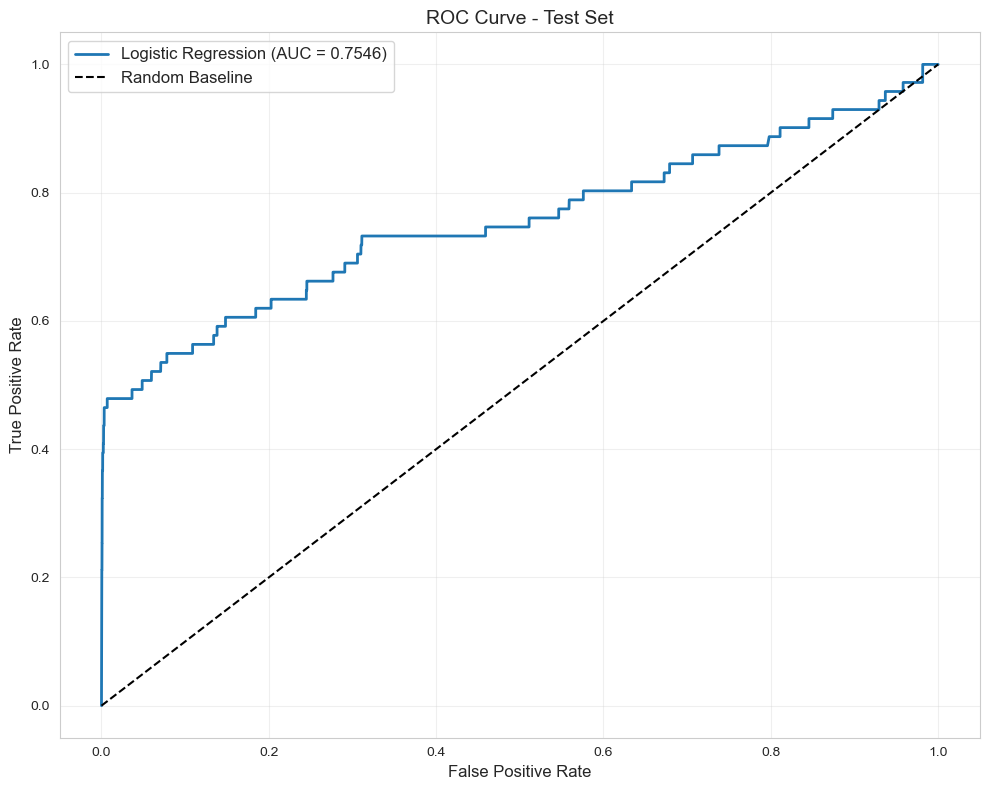

In [32]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_test):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Test Set', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Feature Importance

Top 20 Most Important Features:
                    feature  coefficient  abs_coefficient
                     in_num     1.644491         1.644491
                    out_num     1.343990         1.343990
        out_out_BTC_min_sum     1.042157         1.042157
in_num_output_addresses_sum    -0.967431         0.967431
         in_in_BTC_mean_sum     0.637193         0.637193
out_num_input_addresses_sum     0.590791         0.590791
       in_in_BTC_median_sum     0.565705         0.565705
 in_num_input_addresses_sum     0.548144         0.548144
                in_size_sum     0.542375         0.542375
          in_in_BTC_min_sum     0.533784         0.533784
              out_mean_fees    -0.528640         0.528640
          in_in_BTC_max_sum     0.506813         0.506813
      in_out_txs_degree_sum     0.461131         0.461131
         in_out_BTC_max_sum     0.414578         0.414578
        in_in_BTC_total_sum     0.389548         0.389548
           in_total_BTC_sum     0.389519

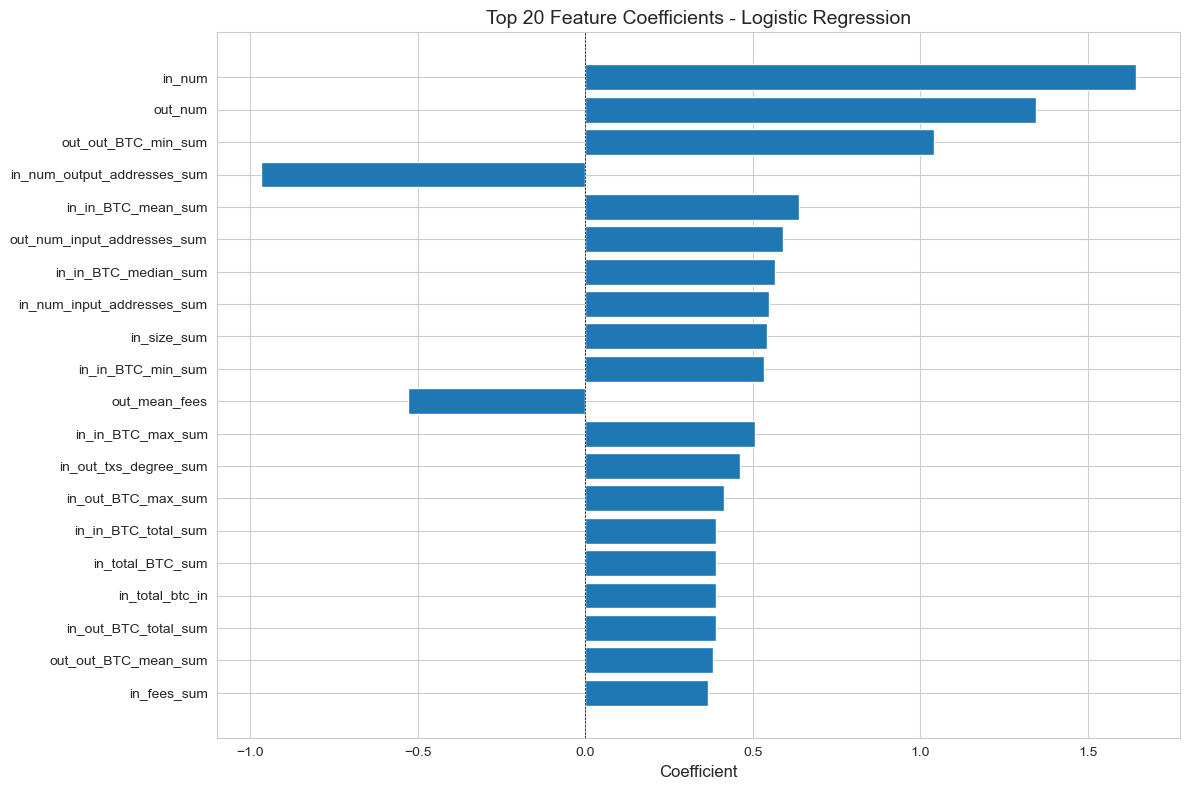

In [33]:
feature_cols = train_balanced_reduced_features.columns.tolist()

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Plot
top_n = 20
top_features = feature_importance.head(top_n)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['coefficient'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient', fontsize=12)
plt.title(f'Top {top_n} Feature Coefficients - Logistic Regression', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Random Forest

In [34]:
# Train random forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
print("✓ Training complete")

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*60)
print("RANDOM FOREST - TEST SET")
print("="*60)
print(classification_report(y_test, y_pred_rf, target_names=['No Future Illicit', 'Future Illicit']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")

Training Random Forest...
✓ Training complete

RANDOM FOREST - TEST SET
                   precision    recall  f1-score   support

No Future Illicit       1.00      0.85      0.92    241362
   Future Illicit       0.00      0.72      0.00        71

         accuracy                           0.85    241433
        macro avg       0.50      0.78      0.46    241433
     weighted avg       1.00      0.85      0.92    241433

ROC-AUC: 0.8554


## Compare Models

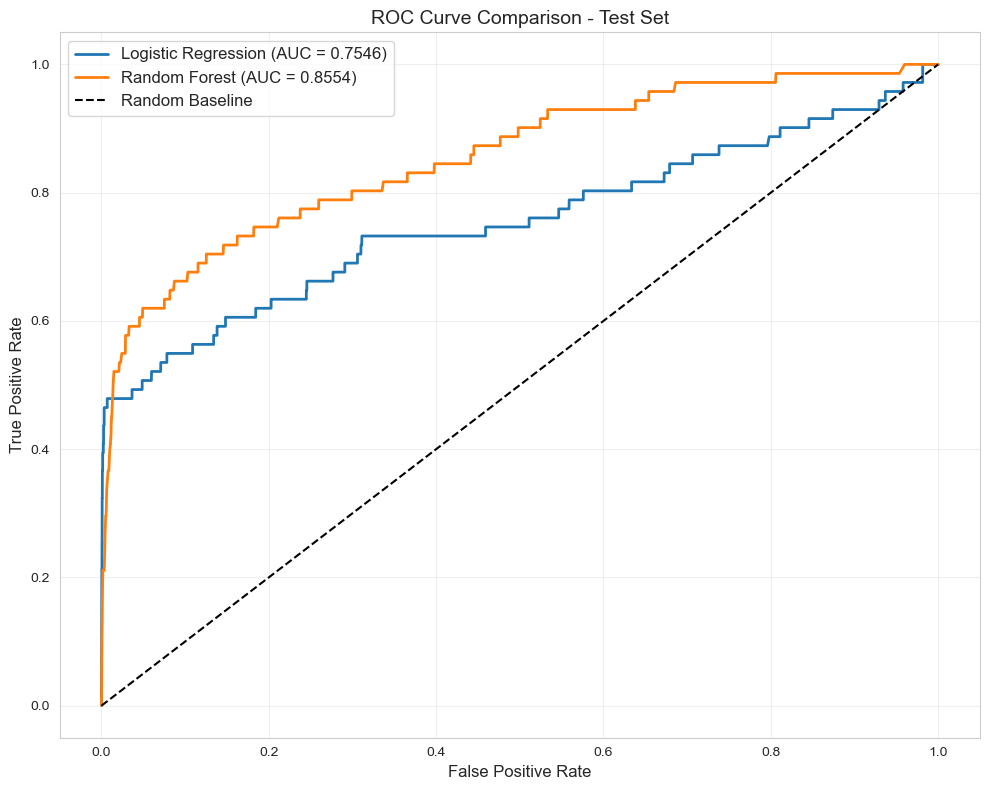

In [36]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_test):.4f})')
plt.plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - Test Set', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()